# Breast cancer array prediction

In [1]:
SEED = 26062019

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.15.4
sklearn version:	0.21.2


## Load data

In [2]:
df_bitm = pd.read_csv(r'data/BITM_Cancer_dataset.csv', sep='\t', header=None)
df_chromPos = pd.read_csv(r'data/Train_call.txt', sep='\t', header=0)
print('nr of entries: ', len(df_bitm))

df_bitm.head()

nr of entries:  100


0           1     2     3     4     5     6     7     8     9     ...  \
0  Array.129       HER2+     0     0     0     0     0     0     0     0  ...   
1   Array.34         HR+     0     0     0     0     0     0     0     0  ...   
2   Array.67         HR+     0     0     0     0     0     0     0     0  ...   
3   Array.24  Triple Neg     0     0     0     0     0     0     0    -1  ...   
4   Array.22  Triple Neg     0     0     0     0     0     0     0     0  ...   

   2826  2827  2828  2829  2830  2831  2832  2833  2834  2835  
0     2     2     2     2     0     1     1     1     1     1  
1     1     1     1     1     1     1     1     1     1     1  
2     1     1     1     1     1     1     1     1     1     1  
3     0     0     0     0     0     0     0     0     0     0  
4     1     1     1     1     1     1     1     1     1     1  

[5 rows x 2836 columns]

In [3]:
class ClinicalInformationRetrieval():
    def __init__(self, df_clinic):
        self.df = df_clinic
        
    def getChrPosition(self, i, offset=-2):
        """
        Specify feature and get corresponding region on chromosome
        Input: 
            i = feature index
        """
        return self.df[['Chromosome', 'Start', 'End']].iloc[i+offset]
    
ch = ClinicalInformationRetrieval(df_chromPos)
print('Test clinical retrieval:\n\n' + str(ch.getChrPosition(9)))


Test clinical retrieval:

Chromosome          1
Start         1676445
End           1703748
Name: 7, dtype: int64


(32, 36, 32)


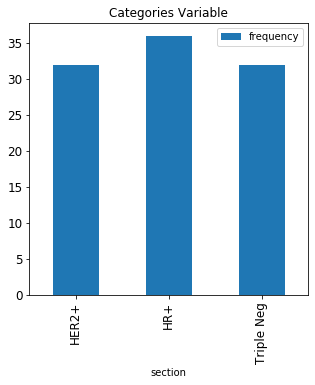

In [4]:
from collections import Counter

labels, values = zip(*Counter(df_bitm[1]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

### Import important modules

In [5]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
import numpy as np

## Feature Reduction

In [107]:
X = df_bitm[df_bitm.columns[2:]]
y = df_bitm[df_bitm.columns[1]]


## Double Cross Validation

Consists of the following steps:
- hyperparameter tuning
- model selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
#from yellowbrick.model_selection import rfecv
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

models = [
    # Support Vector Machine - 1
    Pipeline([
                ('clf', SVC(gamma='auto', random_state=SEED))
            ]),
    # Naive Bayes - 2
    Pipeline([
                ('clf', MultinomialNB()),
            ]),
    # K Nearest Neighbours - 3
    Pipeline([
                ('clf', KNeighborsClassifier()), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Random Forest - 4
    Pipeline([
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    ]

names = ['SVM', 'Naive Bayes', 'KNN', 'Random Forest']
pal = ['r', 'c', 'b', 'y', 'magenta', 'darkgreen', 'indigo', 'black', 'orange'] 

### Feature Selection

In [108]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

SEED = 26062019

X = df_bitm[df_bitm.columns[2:]]

# remove negative values
X = X.replace(2, 3)
X = X.replace(1, 2)
X = X.replace(0, 1)
X = X.replace(-1, 0)

y = df_bitm[df_bitm.columns[1]]

enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)  #['HER2+', 'HR+', 'Triple Neg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

### Lambda regularization - Lasso 10CV
alpha is same as lambda with scikit-learn implementation (Read documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

In [49]:
sfm.get_support()

array([False, False, False, ..., False, False, False])

Before Feature Selection: 2834
After Feature Selection: 40

Final Lambda:  0.026823736896008234


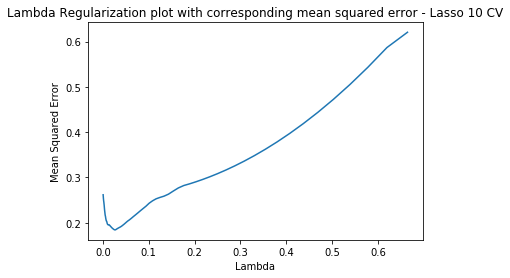

In [10]:
from sklearn.linear_model import LassoCV

# Lasso regression ! 
sfm = SelectFromModel(LassoCV(cv=10))
sfm.fit(X_train,y_train)

print('Before Feature Selection:', len(X_train.columns))
X_train = sfm.transform(X_train) #.shape[1]
print('After Feature Selection:', len(X_train[0]))

x_mean = []
for lst in sfm.estimator_.mse_path_:
    x_mean.append(sum(lst) / len(lst))
print('\nFinal Lambda: ', sfm.estimator_.alpha_)
plt.plot(sfm.estimator_.alphas_, x_mean)
plt.title('Lambda Regularization plot with corresponding mean squared error - Lasso 10 CV')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.savefig('figures/lambda_regularization_lasso.png')

### Double CV

In [11]:
# large folds -> to ensure enough training & validation data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from yellowbrick.model_selection import RFECV
import pickle
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

old_f1 = 0
param = 0
best_model = ''

d_f1_measures = {}

for nr in range(len(models)):
    f1_list = []
    estimator = models[nr]
    if names[nr] == 'SVM':
        param_grid =  {
                'clf__kernel': ['linear', 'poly', 'sigmoid'], # 'rbf' -> not rbf as it is prone to overfitting!
                'clf__C': [ 0.001, 0.01, 0.1, 1, 10, 100], # 0.01, 0.01, 0.1,
            }
    elif names[nr] == 'Random Forest':
        param_grid =  {
            'clf__max_depth': [5, 10, 20, 30],
            'clf__n_estimators': [10, 100]
            }
    elif names[nr] == 'KNN':
        param_grid = { 
            'clf__leaf_size': [5, 10, 20, 30, 40],
            'clf__n_neighbors': [3, 5, 7, 9]
            }
    elif names[nr] == 'Naive Bayes':
        param_grid = { 
            'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
    kfold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
    for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):
        # reset
        
        #kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)
        
        X_tr, y_tr, X_valid, y_valid = X_train[train], y_train[train], X_train[valid], y_train[valid]
        grid = GridSearchCV(estimator, param_grid, cv=5, scoring='f1_micro')

        grid.fit(X_tr, y_tr) 
        y_pred = grid.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='micro')
        print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam
        #print(classification_report(y_valid, y_pred, target_names=['1', '2', '3']))
        f1_list.append(f1)
    if f1 > old_f1:
        print('New Best')
        print('Final F1:', str(f1), 'Best params:', str(grid.best_params_))
        pickle.dump(grid, open('models/model.pkl', 'wb'))
        old_f1 = f1
        param = grid.best_params_
        best_model = names[nr]
    d_f1_measures[names[nr]] = f1_list
        
print('Best model:', best_model, ' F1-final:', old_f1, 'Param:', param)    

C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8947368421052632 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 1.0 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8888888888888888 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8888888888888888 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 1.0 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
New Best
Final F1: 1.0 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
F1: 0.7894736842105263 Best params: {'clf__alpha': 1}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: Depreca

F1: 0.8421052631578947 Best params: {'clf__alpha': 1}
F1: 0.7222222222222222 Best params: {'clf__alpha': 0.1}
F1: 0.8888888888888888 Best params: {'clf__alpha': 1}
F1: 1.0 Best params: {'clf__alpha': 1}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8947368421052632 Best params: {'clf__leaf_size': 20, 'clf__n_neighbors': 9}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.6842105263157895 Best params: {'clf__leaf_size': 20, 'clf__n_neighbors': 7}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.7777777777777778 Best params: {'clf__leaf_size': 5, 'clf__n_neighbors': 9}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.6666666666666666 Best params: {'clf__leaf_size': 5, 'clf__n_neighbors': 3}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.875 Best params: {'clf__leaf_size': 5, 'clf__n_neighbors': 9}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8947368421052632 Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8947368421052632 Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8333333333333334 Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8333333333333334 Best params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
F1: 1.0 Best params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
Best model: SVM  F1-final: 1.0 Param: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## F1-measurements

In [124]:
import matplotlib.pyplot as plt


#names.append('region 2184')
x_pos = np.arange(len(d_f1_measures.keys()))[:4]
l_mean = [] 
l_std = []
for key in list(d_f1_measures.keys())[:4]:
    val = np.array(d_f1_measures[key])
    l_mean.append(np.mean(val))
    l_std.append(np.std(val))
    print(key)
    print(np.mean(val))
    print(np.std(val))

    
# Build the plot
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.bar(x_pos, l_mean, yerr=l_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F1-score +/- std', size=14)
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(names, rotation=0)
ax.set_title('Barplot with micro average F1-score for the different classifiers', size=14)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/f1_modelselection_barplot.png')
plt.show()

SVM
0.9345029239766081
0.053520754098935926
Naive Bayes
0.8485380116959064
0.09386648059524354
KNN
0.7796783625730994
0.09403619693273821
Random Forest
0.8912280701754387
0.06092545738310644


<Figure size 720x720 with 0 Axes>

### Calculate Significance

In [115]:
import scipy

auc_ref = d_f1_measures['SVM']

for key in d_f1_measures.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_f1_measures[key], auc_ref)
    print(key, '(p =', str(twosample_results[1]), ')')

SVM (p = 1.0 )
Naive Bayes (p = 0.15023661540706784 )
KNN (p = 0.02109242359715997 )
Random Forest (p = 0.31699764221596494 )
SVM_2184 (p = 3.35448836537925e-05 )


## Performance on Validation set

In [93]:
import pickle 

best_model = pickle.load(open('models/model.pkl', 'rb'))
print('Before Feature Selection: ', len(X_test.columns))
X_test_t = sfm.transform(X_test) #.shape[1]
print('After Feature Selection: ', len(X_test_t[0]))
y_pred =  best_model.predict(X_test_t)
f1 = f1_score(y_test, y_pred, average='micro')
print('F1 final:', str(f1), 'Best params:', str(best_model.best_params_))  # print best hyperparam
print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))

Before Feature Selection:  2834
After Feature Selection:  40
F1 final: 1.0 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [11]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=14)

    plt.ylabel('True label', size=14)
    plt.xlabel('Predicted label', size=14)
    plt.tight_layout()
    return plt
    

cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plt = plot_confusion_matrix(cnf_matrix, classes=['HER2+', 'HR+', 'Triple Neg'],
                      title='Confusion matrix, without normalization')
plt.savefig("figures/cm_SVM_validation.png")


## Determine best regions

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, i, top_features=20):
    names = ['HER2+', 'HR+', 'Triple Neg']
    coef = classifier.best_estimator_.named_steps['clf'].coef_[i] #.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    plt.savefig("figures/coef_plot_biomarkers_" + names[i] +".png")
    plt.show()
    
    d = {'id' : feature_names, 'hp' + str(i) + '_coef': coef}
    df = pd.DataFrame(data=d)
    return df

# Retrieve features from initial fold features
offset = 2
df_coef_new = plot_coefficients(best_model, [i-offset for i in list(X_test[X_test.columns[sfm.get_support()]].columns)], i=2)

In [101]:
df_coef['Chromosome'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[0])
df_coef['Start'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[1])
df_coef['End'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[2])
df_coef.head()

id  hp1_coef  Chromosome      Start        End  hp2_coef  hp0_coef
0  177 -0.113222           1  120405944  120737345 -0.166064  0.014277
1  192  0.090740           1  146581869  146634734  0.284539  0.037482
2  230 -0.040233           1  193652057  199041703 -0.003700 -0.071363
3  486 -0.089089           3  193425674  193467200 -0.056707 -0.164589
4  576  0.025135           4   93240865  100160841  0.187209  0.053722

In [114]:
#df_coef.sort_values('coef').to_csv(r'results/SVM_biomarkers_coefs.csv', index=False)
df_coef[['id', 'Chromosome', 'Start', 'End', 'hp0_coef', 'hp1_coef', 'hp2_coef']].sort_values('hp1_coef', ascending=False).to_csv(r'results/SVM_biomarkers_coefs_total.csv', index=False)

In [99]:
df_coef.sort_values('coef').tail()

id      coef  Chromosome     Start       End
14  1243  0.123815           9  39355550  40238048
18  1656  0.130052          12  63340667  63566937
22  1881  0.135231          15  18362555  18431773
24  1902  0.138611          15  32447707  32511475
33  2184  0.646124          17  34900309  34977994

### Most informative region : Coefficient 2184?

In [118]:
import matplotlib.pyplot as plt

names = ['Hyperplane 1:\nHER2+ vs. HR+', 'Hyperplane 2:\nHER2+ vs. Triple Neg', 'Hyperplane 3:\nHR+ vs. Triple Neg']
val = [0.933, 0.646, 0.262] # directly obtained from feature plot
x_pos = np.arange(len(val))

# Build the plot
plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
ax.bar(x_pos, val, align='center', alpha=0.5, ecolor='black', color=['r', 'b', 'green'],capsize=10)
ax.set_ylabel('Relative size', size=14)
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(names, rotation=0)
ax.set_title('Size of coefficient 2184 for each hyperplane', size=14)
ax.set_ylim(0,1)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

for i,j in zip(x_pos,val):
    ax.annotate(str(j),xy=(i-0.11,j+0.01), size=14)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/coef_2184_barplot.png')
plt.show()

<Figure size 288x288 with 0 Axes>

## Employ Naive Model (Single Best Region)


In [33]:
offset = 2
feature_actual = 2184

feature_id = feature_actual + offset
print(feature_id)

X_train_naive = X_train[feature_id].values.reshape(-1, 1)
X_test_naive = X_test[feature_id].values.reshape(-1, 1)

old_f1 = 0
param = 0
best_model = ''

f1_list = []
estimator = SVC(gamma='auto', random_state=SEED)
kfold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
param_grid =  {
                'kernel': ['linear', 'poly', 'sigmoid'],
                'C': [ 0.01, 0.01, 0.1, 1, 10, 100], 
        }

for i, (train, valid) in enumerate(kfold_outer.split(X_train_naive, y_train)):
    # reset

    #kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)

    X_tr, y_tr, X_valid, y_valid = X_train_naive[train], y_train[train], X_train_naive[valid], y_train[valid]
    grid = GridSearchCV(estimator, param_grid, cv=5, scoring='f1_micro')

    grid.fit(X_tr, y_tr) 
    y_pred = grid.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam

    f1_list.append(f1)
if f1 > old_f1:
    print('New Best')
    print('Final F1:', str(f1), 'Best params:', str(grid.best_params_))
    pickle.dump(grid, open('models/region_model_' + str(feature_actual) +'.sav', 'wb'))
    old_f1 = f1
    param = grid.best_params_
    best_model = 'SVM_' + str(feature_actual)
d_f1_measures['SVM_' + str(feature_actual)] = f1_list
        
print('Best model:', best_model, ' F1-final:', old_f1, 'Param:', param)    

C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.6842105263157895 Best params: {'C': 0.01, 'kernel': 'poly'}
F1: 0.6842105263157895 Best params: {'C': 0.01, 'kernel': 'poly'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.7222222222222222 Best params: {'C': 0.01, 'kernel': 'poly'}
F1: 0.7222222222222222 Best params: {'C': 0.01, 'kernel': 'poly'}
F1: 0.6875 Best params: {'C': 0.01, 'kernel': 'poly'}
New Best
Final F1: 0.6875 Best params: {'C': 0.01, 'kernel': 'poly'}
Best model: SVM_2184  F1-final: 0.6875 Param: {'C': 0.01, 'kernel': 'poly'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [91]:
import pickle 

best_model = pickle.load(open('models/region_model_2184.sav', 'rb'))
y_pred =  best_model.predict(X_test_naive)
f1 = f1_score(y_test, y_pred, average='micro')
print('F1 final:', str(f1), 'Best params:', str(best_model.best_params_))  # print best hyperparam
print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))

F1 final: 0.5 Best params: {'C': 0.01, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.29      1.00      0.44         2
           2       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.43      0.67      0.48        10
weighted avg       0.36      0.50      0.39        10



C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plt = plot_confusion_matrix(cnf_matrix, classes=['HER2+', 'HR+', 'Triple Neg'],
                      title='Confusion matrix, without normalization')
plt.savefig("figures/cm_single_region_validation.png")

Confusion matrix, without normalization
[[3 0 0]
 [0 2 0]
 [0 5 0]]


In [82]:
import matplotlib.pyplot as plt

#names.append('region 2184')
x_pos = [0, 1]
l_mean = [] 
l_std = []
for key in ['SVM', 'SVM_2184']:
    val = np.array(d_f1_measures[key])
    l_mean.append(np.mean(val))
    l_std.append(np.std(val))
    print(key)
    print(np.mean(val))
    print(np.std(val))
    
color=['b','orange']
    
# Build the plot

fig, ax = plt.subplots()
ax.figsize=(6,3)
ax.bar(x_pos, l_mean, yerr=l_std, align='center', alpha=0.5, ecolor='black', color=color, capsize=12)
ax.set_ylabel('F1-score +/- std', size=14)
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major')
ax.set_xticklabels(['SVM', 'region 2184'], rotation=0, size=14)
ax.set_title('Barplot with micro average F1-score for the different classifiers', size=14)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/f1_optimal_vs_region_barplot.png')
plt.show()

SVM
0.9345029239766081
0.053520754098935926
SVM_2184
0.7000730994152047
0.01812452792110122


### New estimate calculation with a Nested CV (to respond to feedback)

In [115]:
# large folds -> to ensure enough training & validation data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LassoCV

def warn(*args, **kwargs): # way too many warnings otherwise
    pass
import warnings
warnings.warn = warn

kfold_valid = StratifiedKFold(n_splits=10, random_state=SEED)  
f1_list = []
d_f1_measures = {}
for j, (tr, te) in enumerate(kfold_valid.split(X, y)):
    old_f1 = 0
    param = 0
    best_model = ''
    X_train, y_train, X_test, y_test = X.loc[tr], y[tr], X.loc[te], y[te]
    
    
    sfm = SelectFromModel(LassoCV(cv=10))
    sfm.fit(X_train,y_train)

    #print('Before Feature Selection:', len(X_train.columns))
    X_train = sfm.transform(X_train) #.shape[1]
    #print(X_train.shape[1])
    #print('After Feature Selection:', len(X_train[0]))
    
    for nr in range(len(models)):
        
        estimator = models[nr]
        if names[nr] == 'SVM':
            param_grid =  {
                    'clf__kernel': ['linear', 'sigmoid'], # 'rbf' 'poly',-> not rbf as it is prone to overfitting!
                    'clf__C': [ 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # 0.01, 0.01, 0.1,
                }
        elif names[nr] == 'Random Forest':
            param_grid =  {
                'clf__max_depth': [5, 10, 20, 30],
                'clf__n_estimators': [10, 100]
                }
        elif names[nr] == 'KNN':
            param_grid = { 
                'clf__leaf_size': [5, 10, 20, 30, 40],
                'clf__n_neighbors': [3, 5, 7, 9]
                }
        elif names[nr] == 'Naive Bayes':
            param_grid = { 
                'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
                }
        kfold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
        for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):
            # reset

            #kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)

            X_tr, y_tr, X_valid, y_valid = X_train[train], y_train[train], X_train[valid], y_train[valid]
            grid = GridSearchCV(estimator, param_grid, cv=5, scoring='f1_micro')

            grid.fit(X_tr, y_tr) 
            y_pred = grid.predict(X_valid)
            f1 = f1_score(y_valid, y_pred, average='micro')
            #print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam
            #print(classification_report(y_valid, y_pred, target_names=['1', '2', '3']))
            
            if f1 > old_f1:
                pickle.dump(grid, open('models/optimal_model.sav', 'wb'))
                old_f1 = f1
                param = grid.best_params_
                best_model = names[nr]
            
    # load best model
    #print(str(j) + ' Best model:', best_model, ' F1:', old_f1, 'Param:', param) 
    #print('Best model (test):', )
    print('Employing best model on test set:')

    actual_model = pickle.load(open('models/optimal_model.sav', 'rb'))
    y_pred =  actual_model.predict(sfm.transform(X_test))
    f1 = f1_score(y_test, y_pred, average='micro')
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='micro')
    recall = precision_score(y_test, y_pred, average='micro')
    f1_list.append(f1)

    #print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))
    print(str(j), 'F1-final:', f1, 'Precision:', prec, 'Recall:', recall,'Accuracy:', acc)
    d_f1_measures[best_model+str(j)] = [f1, acc, prec, recall]
    
        
    

Employing best model on test set:
0 F1-final: 0.75 Precision: 0.75 Recall: 0.75 Accuracy: 0.75
Employing best model on test set:
1 F1-final: 0.8333333333333334 Precision: 0.8333333333333334 Recall: 0.8333333333333334 Accuracy: 0.8333333333333334
Employing best model on test set:
2 F1-final: 0.7 Precision: 0.7 Recall: 0.7 Accuracy: 0.7
Employing best model on test set:
3 F1-final: 0.8000000000000002 Precision: 0.8 Recall: 0.8 Accuracy: 0.8
Employing best model on test set:
4 F1-final: 1.0 Precision: 1.0 Recall: 1.0 Accuracy: 1.0
Employing best model on test set:
5 F1-final: 0.7 Precision: 0.7 Recall: 0.7 Accuracy: 0.7
Employing best model on test set:
6 F1-final: 0.6666666666666666 Precision: 0.6666666666666666 Recall: 0.6666666666666666 Accuracy: 0.6666666666666666
Employing best model on test set:
7 F1-final: 0.8888888888888888 Precision: 0.8888888888888888 Recall: 0.8888888888888888 Accuracy: 0.8888888888888888
Employing best model on test set:
8 F1-final: 0.7777777777777778 Precisio

### write to estimate.txt

In [117]:
f1_mean = 0
for key in d_f1_measures.keys():
    f1_mean +=d_f1_measures[key][0]
        
print(f1_mean/10)

estimate = (f1_mean/10) * 57

with open('estimate.txt', 'w') as f:
    f.write(str(round(estimate)))

0.7894444444444446


## Final Model

Run the following command in the terminal for the final result
```{sh}

python run_model.py -i data/Validation_call.txt -m models/model.pkl -o predictions.txt

```